# **Predecir la rotación en el entorno laboral** 

Voy a intentar crear un modelo que, a partir de diferentes datos de los empleados de una empresa, pueda predecir la rotación o attrition, entendida como la probabilidad de que la persona abandone la compañía en el futuro.

Estos datos los encontré en: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study/data

Antes que nada, algunos datos de la empresa:

- 4K empleados
- Rotación de aproximadamente el 15% (contemplando bajas voluntarias y despidos), con un impacto muy alto en negocio.

El objetivo sería:
- Realizar un modelo para predecir el attrition utilizando la regresión logística
- Implementar posibles cambios en el lugar de trabajo para intentar disminuirla

En este caso, vamos a trabajar con 3 BBDD que contienen:

- *general_data*: información sobre los empleados, incluyéndose aquí el dato clave de rotación;

- *employee_survey_data*, donde se incluyen variables que pueden ser clave para la attrition (satisfacción con el ambiente laboral, el trabajo y el balance entre trabajo y vida personal);

- *manager_survey_data*, donde se incluyen valoraciones de desempeño de los empleados y valoración de su nivel de compromiso (desconocemos la escala o metodología utilizada).

In [1]:
# Empezamos con la fase de análisis explotario de los datos, ya que es un nuevo dataset que no trabajé en la anterior entrega.

import pandas as pd
import numpy as np

general_data = pd.read_csv('DataSet\general_data.csv')
employee_survey = pd.read_csv('DataSet\employee_survey_data.csv')
manager_survey = pd.read_csv('DataSet\manager_survey_data.csv')

In [2]:
# Unimos los tres con un merge utilizando el ID de empleado

data = general_data.merge(employee_survey, on='EmployeeID', how='left')
data = data.merge(manager_survey, on='EmployeeID', how='left')

In [3]:
# vemos a través de info si existe algún valor nulo en algunas de las columnas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [4]:
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [5]:
# Aquí vemos el número exacto de nulos que tenemos por categoría
data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
dtype: int64

In [6]:
# decido sustituir los valores faltantes por la mediana, para evitar el impacto que tienen los outliers sobre la media

numeric_columns = data.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    data[column] = data[column].fillna(data[column].median())

print(data.isnull().sum())

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64


In [7]:
# Ahora codificamos las variables categóricas, como el género

# Codificar variables categóricas en booleanas (ponemos el drop_first true para evitar la colinealidad de las variables, elimina una columna por categoría)
data = pd.get_dummies(data, drop_first=True)

In [8]:
data

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,1,1,1,131160,1.0,11,8,...,False,False,False,False,False,False,False,False,True,False
1,31,10,1,1,2,1,41890,0.0,23,8,...,False,False,False,False,False,True,False,False,False,True
2,32,17,4,1,3,4,193280,1.0,15,8,...,False,False,False,False,False,False,True,False,True,False
3,38,2,5,1,4,3,83210,3.0,11,8,...,True,False,False,False,False,False,False,False,True,False
4,32,10,1,1,5,1,23420,4.0,12,8,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,1,4406,1,60290,3.0,17,8,...,False,False,False,False,False,True,False,False,False,True
4406,29,2,4,1,4407,1,26790,2.0,15,8,...,False,True,False,False,False,False,False,False,False,False
4407,25,25,2,1,4408,2,37020,0.0,20,8,...,False,False,False,False,False,False,True,False,True,False
4408,42,18,2,1,4409,1,23980,0.0,14,8,...,False,True,False,False,False,False,False,False,False,False


In [9]:
# Hacemos la matriz de correlación para tener una visión a alto nivel de las variables que pueden estar impactando en el attrition
data.corr()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
Age,1.000000,0.006963,-0.035706,NaN,0.008649,-0.002884,-0.044314,0.298869,-0.033137,NaN,...,0.001194,0.033969,0.009020,0.001261,-1.605906e-02,0.005834,0.008219,-0.014096,0.083919,-0.119185
DistanceFromHome,0.006963,1.000000,-0.008638,NaN,-0.001097,-0.037329,-0.021607,-0.013514,0.038125,NaN,...,0.001813,0.052249,-0.038859,0.000305,-3.848864e-03,-0.002360,-0.012479,0.005463,0.038151,-0.042204
Education,-0.035706,-0.008638,1.000000,NaN,-0.009680,0.045746,0.006410,-0.016195,-0.040531,NaN,...,0.045063,-0.077518,0.044142,-0.011976,4.969407e-02,0.000709,-0.004180,0.032320,-0.008534,0.024114
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeID,0.008649,-0.001097,-0.009680,NaN,1.000000,-0.003303,0.007338,-0.000789,-0.004456,NaN,...,-0.008991,-0.008073,-0.001464,0.013529,-2.202476e-03,-0.004666,0.001284,0.009162,0.000419,0.000823
JobLevel,-0.002884,-0.037329,0.045746,NaN,-0.003303,1.000000,0.047316,-0.010116,0.010973,NaN,...,0.028870,-0.031566,0.025348,-0.004684,3.220675e-02,0.017455,-0.021969,-0.024790,0.007360,-0.021163
MonthlyIncome,-0.044314,-0.021607,0.006410,NaN,0.007338,0.047316,1.000000,-0.020515,0.004325,NaN,...,-0.026453,0.012624,-0.009477,0.029201,2.262309e-03,-0.000567,0.001785,0.001776,0.020189,-0.051774
NumCompaniesWorked,0.298869,-0.013514,-0.016195,NaN,-0.000789,-0.010116,-0.020515,1.000000,0.031062,NaN,...,0.025142,0.006789,-0.005619,0.003980,1.321207e-02,-0.019840,-0.019397,0.013684,-0.015116,-0.020569
PercentSalaryHike,-0.033137,0.038125,-0.040531,NaN,-0.004456,0.010973,0.004325,0.031062,1.000000,NaN,...,-0.035124,0.039401,-0.003199,-0.017697,-9.640495e-03,-0.009871,-0.041760,0.066547,-0.015678,0.013365
StandardHours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


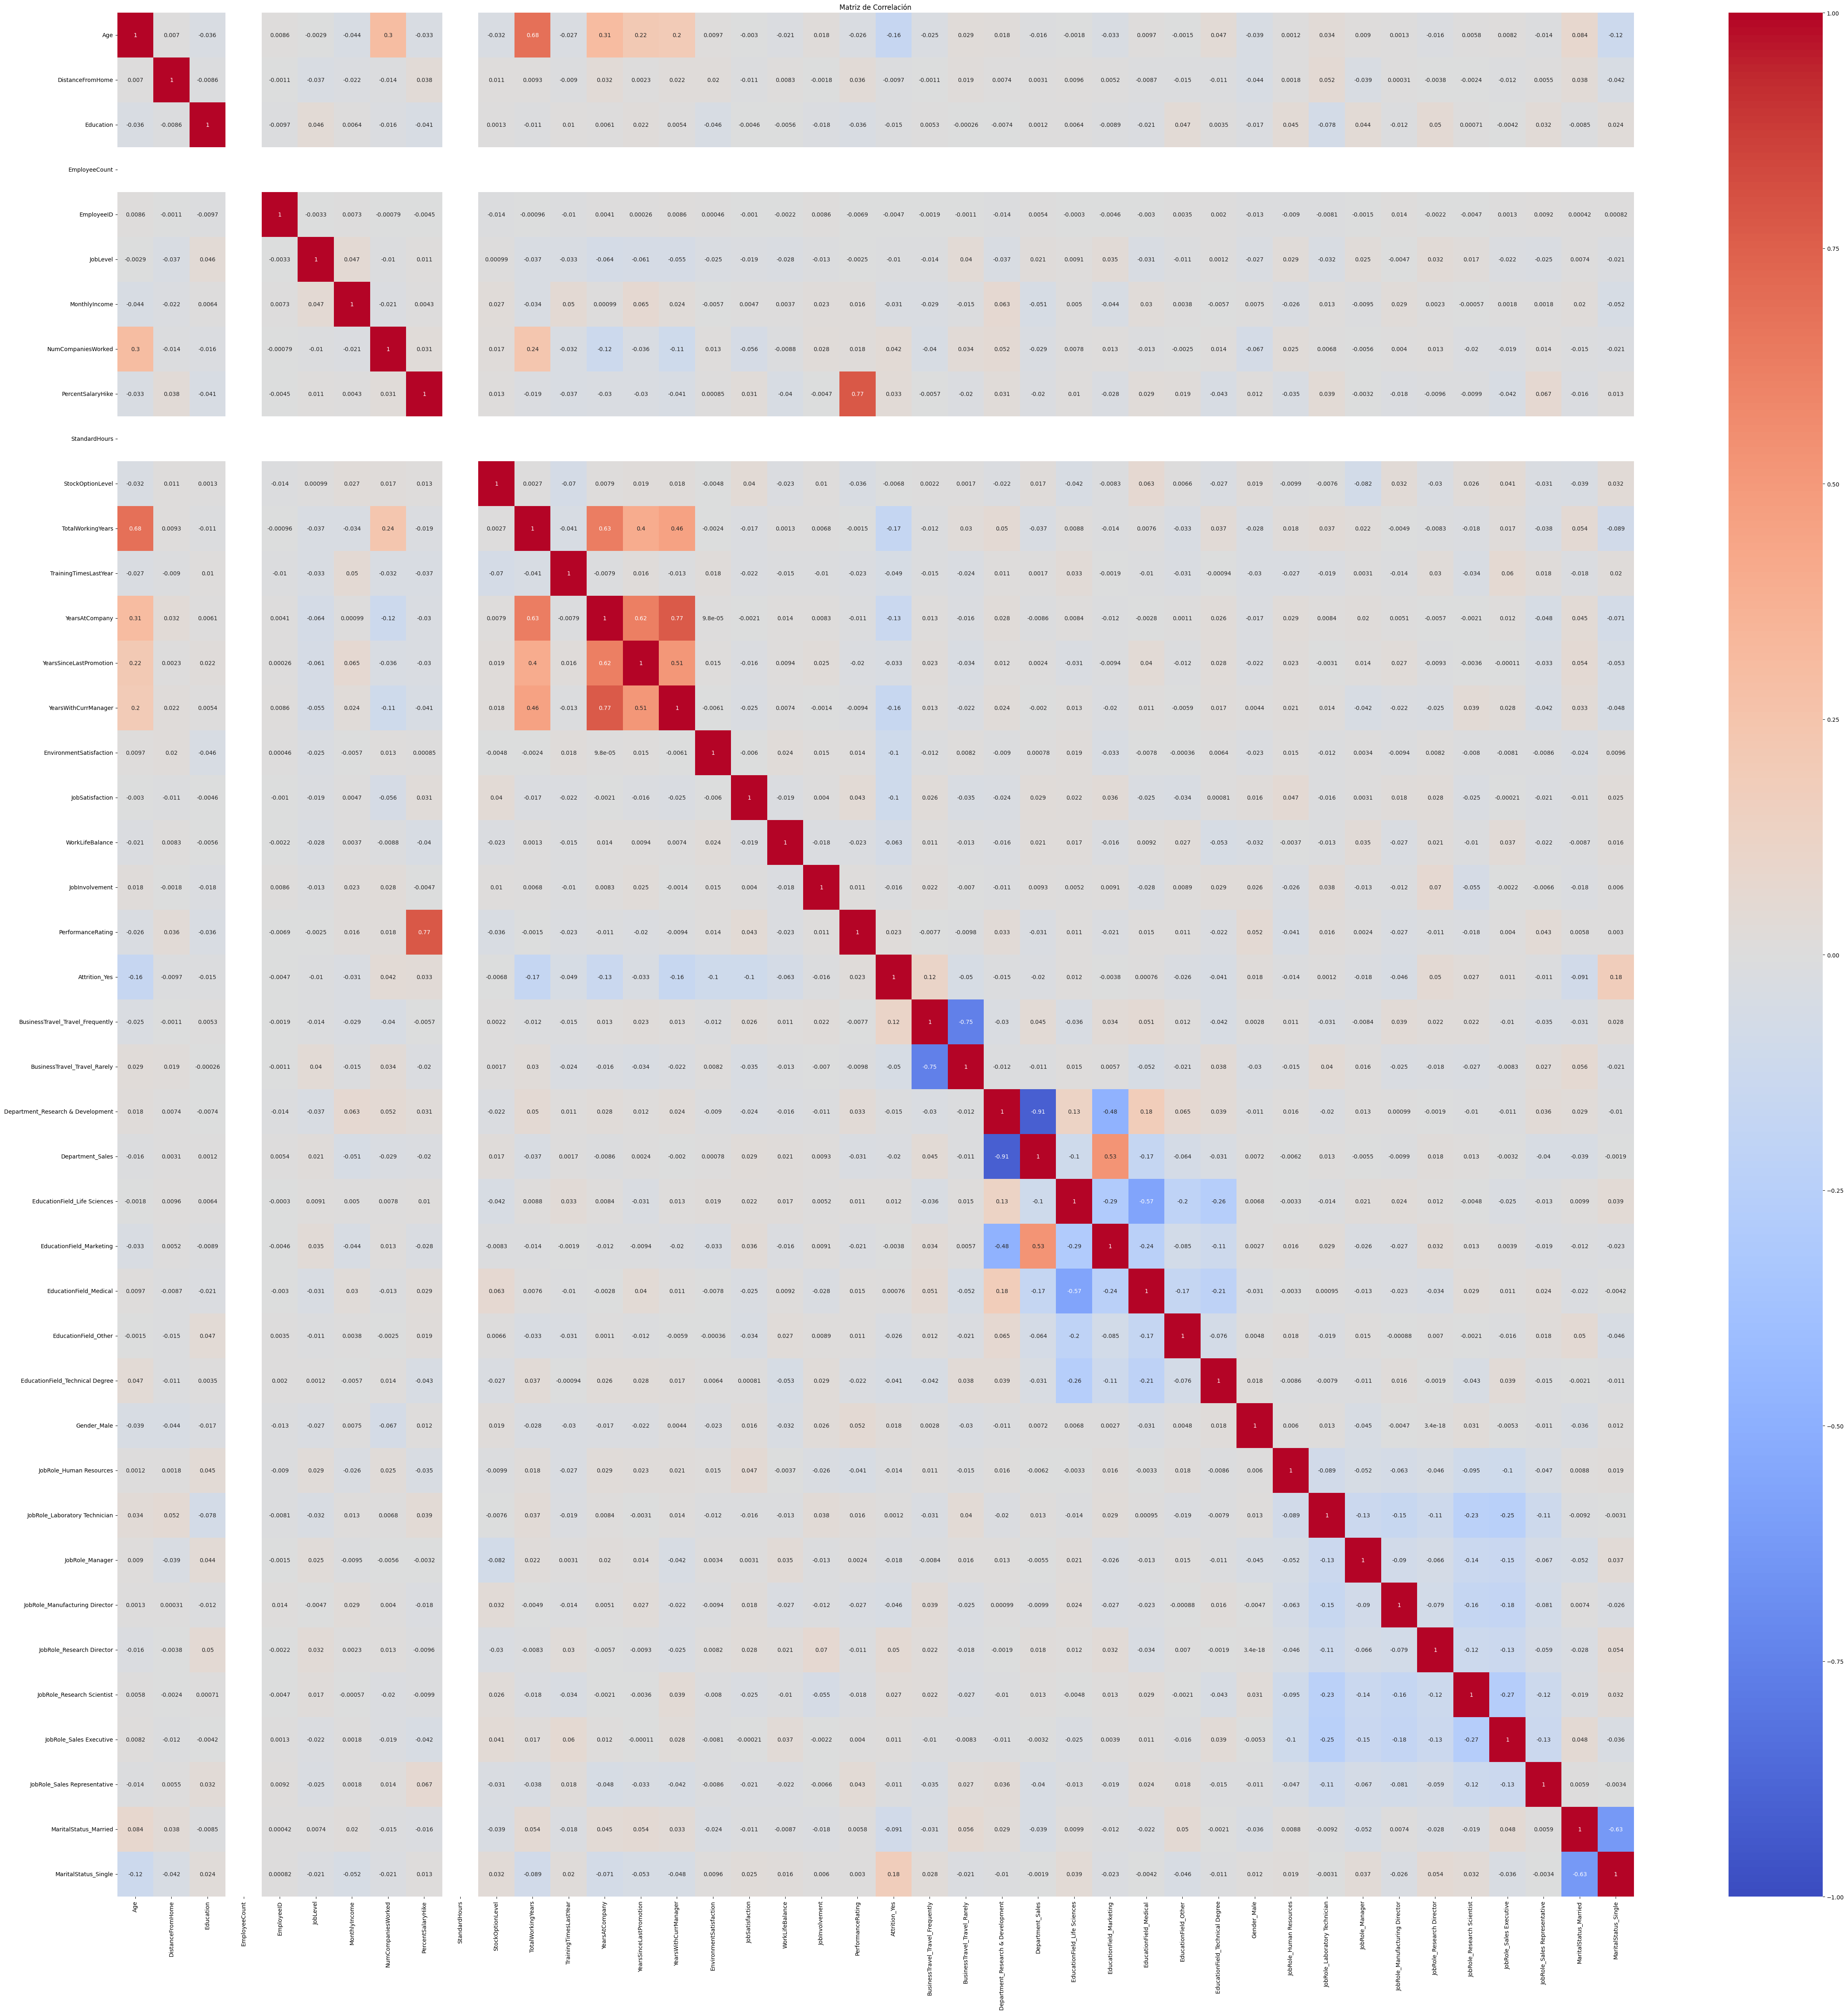

In [10]:
# Pintamos la matriz en modo mapa de calor para que nos dé la información de una forma más visual, centrándonos solo en el attrition
corr_matrix = data.corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(60, 60))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

In [11]:
'''
Las correlaciones más interesantes en el caso del atrittion son:

-0.16 con la edad
-0.17 con total working years (ojo, relacionada con la anterior)
-0.13 con los años de antigüedad (ojo, relacionada con la primera) - YearsAtCompany
-0.16 con años con el manager actual
-0.1 con la satisfacción con el entorno de trabajo
-0.1 con la satisfacción con el trabajo
-0.063 con el equilibrio con la vida personal
-0.12 con la frecuencia con la que se viaja
0.18 con estar soltero/a
-0.091 con estar casado

'''

''' 
Posibles conclusiones:

mayor attrition en personas más jóvenes, con menos años de antigüedad y experiencia;
mayor attrition en personas que están descontentas con el entorno de trabajo y el trabajo en sí
mayor attrition en personas que viajan menos
mayor attrition en personas solteras que de cualquier otro estado civil

'''

' \nPosibles conclusiones:\n\nmayor attrition en personas más jóvenes, con menos años de antigüedad y experiencia;\nmayor attrition en personas que están descontentas con el entorno de trabajo y el trabajo en sí\nmayor attrition en personas que viajan menos\nmayor attrition en personas solteras que de cualquier otro estado civil\n\n'

In [12]:
# Preparamos los datos para hacer el modelo de regresión logística, que en este caso es interesante para clasificar a los usuarios de manera binaria

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Variable y variable a predecir
X = data.drop(['Attrition_Yes', 'EmployeeID', 'EmployeeCount', 'StandardHours','YearsSinceLastPromotion','JobSatisfaction','JobInvolvement'], axis=1)
y = data['Attrition_Yes']

# Dividimos entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Estandarización y fit
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.98      0.91       741
        True       0.58      0.13      0.22       141

    accuracy                           0.85       882
   macro avg       0.72      0.56      0.57       882
weighted avg       0.81      0.85      0.80       882

Precision: 0.5757575757575758
Recall: 0.1347517730496454


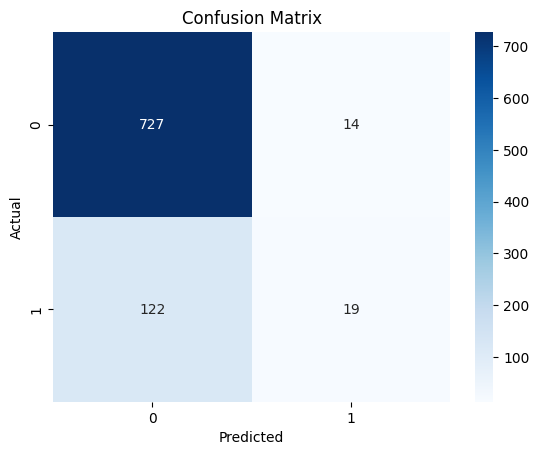

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Construir el modelo
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3528, 35)
(882, 35)
(3528,)
(882,)
